# Example of OmnisciDB UDTF: table column normalization

The aim of this notebook is to demonstrate how to implement with a help of [RBC](https://github.com/xnd-project/rbc/) tool a OmnisciDB User-Defined Table Function (UDTF) in Python that normalizes a table column using the following formula:

```
  normalize(X) = (X - mean(X)) / std(X)
```


## Connecting to OmnisciDB server

First, let us establish a connection to the OmnisciDB server using the tools from the RBC project:

In [1]:
import warnings; warnings.filterwarnings('ignore')

In [2]:
from rbc.omniscidb import RemoteOmnisci
omnisci = RemoteOmnisci(host='127.0.0.1', port=6274)
print(f'Connecting to OmnisciDB version {omnisci.version}, cuda={omnisci.has_cuda}')
assert omnisci.version[:3] >= (5, 4, 0), omnisci.version
assert not omnisci.has_cuda

Connecting to OmnisciDB version (5, 4, 0, '-20200908-7002f5efb7'), cuda=None


This notebook requires CUDA-disabled OmnisciDB version 5.4 or newer. If the above fails or one is connected to older version of OmnisciDB, please resolve the issue before continuing.

## Test data

Next, let's create a test data that will be a sequence of 500 random numbers drawn from normal distribution with average value 10 and standard deviation 2:

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import randn
SQL=lambda query: np.array(list(omnisci.sql_execute(query)[1]))
SQL('DROP TABLE IF EXISTS test_data');
SQL('CREATE TABLE IF NOT EXISTS test_data (X DOUBLE)')
omnisci.load_table_columnar('test_data', X=np.random.randn(500) * 2 + 10)

Let's verify that the created table `test_data` contains the expected data by retriving the data and using numpy methods for analyzing it locally:

9.864146769457747 2.1192611790584985


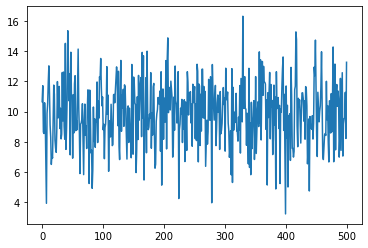

In [4]:
X = SQL('SELECT X FROM test_data')     # X will be a ndarray with shape (500, 1)
X = X[:, 0]                            # normalize X to 1-D array
print(np.mean(X), np.std(X, ddof=1))   # print the mean and unbiased std of X
plt.plot(X);

# Necessity of UDF/UDTF for analyzing large data sets

For very large data sets retrieving the data set to a local system for analysis may be impractical because of network bandwidth or the local system may not have enough RAM to hold the data. In such situations it becomes necessary to implement analyzing tools locally but so that the tools are executed in the server system that holds the data.

OmnisciDB server v 5.4 implements support for users to define UDFs and UDTFs in runtime. UDFs can be applied to table data row-by-row, hence UDFs are data item-wise functions and UDFs return a scalar value. UDTFs, on the other hand, can be applied to table data columns and UDTFs return a table. Hence we call UDTFs also as table functions. 

The UDFs and table functions can be defined as Python functions using the [RBC](https://github.com/xnd-project/rbc/) tool that exploits [Numba](https://numba.pydata.org/) to convert Python functions to [LLVM](https://en.wikipedia.org/wiki/LLVM) IR strings and that are registered in the OmnisciDB server as User-Defined SQL functions so that the LLVM IR will be compiled into the SQL queries of the OmnisciDB server.

## Analyze data remotely using OmnisciDB user-defined functions

### Unbiased standard deviation

As an example of UDTF, let's implement a standard deviation function in Python using Welford's online algorithm:

In [5]:
def std_welford(x):
    A = 0.0  # running mean value
    Q = 0.0  # running var value
    for i in range(len(x)):
        xi = x[i]
        A1 = A + (xi - A) / (i + 1)
        Q = Q + (xi - A) * (xi - A1)
        A = A1
    return pow(Q / (len(x) - 1), 0.5)

# Compare the results of std_welford and numpy.std function:
print(f'std_welford(X), numpy.std(X, ddof=1) -> {std_welford(X), np.std(X, ddof=1)}')

std_welford(X), numpy.std(X, ddof=1) -> (2.119261179058499, 2.1192611790584985)


The `std_welford` takes a sequence `x` as input and returns a `std` as scalar value. To run this function on the data stored in OmnisciDB server, we create an OmnisciDB table function as follows:

In [6]:
import numba
numba_std_welford = numba.njit(std_welford)  # register for numba

# register a UDTF as a new SQL function std in OmnisciDB server 
@omnisci('int32(Column<double>, int32|sizer=RowMultiplier, OutputColumn<double>)')
def unbiased_std(x, m, out):
    out[0] = numba_std_welford(x) # store the computed std value in UDTFs output argument
    return 1                      # return the size of output column

Notice that table functions are annotated differently from UDFs. The following applies to all table functions:

- A `omnisci`-decorated function is considered a UDTF when it's signature contains `Column` and `OutputColumn` arguments. Otherwise, the function defines a UDF.

- A table function input column arguments must have type `Column<row-type>` where `row-type` is a type specification for column entries. The currently supported row types are `float`, `double`, `int8`, `int16`, `int32`, `int64`, and `bool`. All column input arguments have equal sizes. The input column arguments must be specified in SQL queries via `CURSOR` construction.

- A table function must have `sizer` argument that has type `int64` and is bar-annotated with `sizer=<sizer-type>` where currently supported `sizer-type` is `RowMultiplier`. The value of `sizer` defines the pre-allocated memory size of output arguments, see below. The sizer argument must be specified in SQL queries using a literal integer value.

- A table function output column arguments must have type `OutputColumn<row-type>`. The output column arguments use pre-allocated memory that size is equal to `<sizer value> * <size of input columns>`.

- A table function must return the actual size of output column arguments as `int32` value that will be used for reallocating the memory of output column arguments. Table functions are called in SQL queries using `TABLE` construction.

For example, the table function `unbiased_std` takes three arguments: `x` is input column argument, `m` is sizer argument, and `out` is output column argument. For the sizes of column arguments, `len(out) == m * len(x)` holds. The table function returns `1` that indicates to OmnisciDB query engine that the size of output column `out` is equal to `1` and the engine will reallocate the `out` memory accordingly.

Now let's compute the standard deviation in the server:

In [7]:
SQL('SELECT * FROM TABLE(unbiased_std(CURSOR(SELECT X FROM test_data), 1));')

array([[2.11926118]])

Notice that the retrived value matches with the result of locally computed standard deviation values.

### Normalize a table column

To normalize a table column containing random data using a formula:
```
normalize(X) = (X - mean(X))/std(X)
```
we apply the following UDF to a table column:

In [8]:
@omnisci('double(double, double, double)')
def normalize_udf(x, mean, std):
    return (x - mean)/std

In [9]:
X_udf = SQL('SELECT normalize_udf(X, 10, 2) FROM test_data')
print(f'mean(X_udf)={np.mean(X_udf):.3f}, std(X_udf)={np.std(X_udf, ddof=1):.3f}')

mean(X_udf)=-0.068, std(X_udf)=1.060


As expected, the mean of a normalized column is close to 0 and the standard deviation is close to 1.

In case the mean and standard deviation of the data column are unknown, we can compute the mean and std using the Welford algorithm and normalize the data in a single call to the following table function:

In [10]:
@omnisci('int32(Column<double>, int32|sizer=RowMultiplier, OutputColumn<double>)')
def normalize_udtf(x, m, out):
    A = 0.0                         # running mean value
    Q = 0.0
    for i in range(len(x)):
        xi = x[i]
        A1 = A + (xi - A) / (i + 1)
        Q = Q + (xi - A) * (xi - A1)
        A = A1
    s = pow(Q / (len(x) - 1), 0.5)   # unbiased std value
    for i in range(len(x)):
        out[i] = (x[i] - A) / s
    return len(x)                    # return the size of output column

In [11]:
X_udtf = SQL('SELECT * FROM TABLE(normalize_udtf(CURSOR(SELECT X FROM test_data), 1))')
print(f'mean(X_udtf)={np.mean(X_udtf):.3f}, std(X_udtf)={np.std(X_udtf, ddof=1):.3f}')

mean(X_udtf)=-0.000, std(X_udtf)=1.000


As expected, the mean and std values of normalized sequence are exactly 0 and 1, respectively.

### Final notes

- Table functions currently work only on CUDA-disabled OmnisciDB server.
- SQL aggregate functions and likely other operations do not work on table functions, for example:


In [12]:
try:
    SQL('SELECT AVG(out0) FROM TABLE(normalize_udtf(CURSOR(SELECT X FROM test_data), 1))')
except Exception as msg:
    print(msg)

TMapDException(error_msg='Exception: Aggregate on ColumnDOUBLE[] is not supported yet.')


As a workaround, one can save the table function result in a auxiliary table and apply SQL operations to it's columns:

In [13]:
SQL('DROP TABLE IF EXISTS result_data');
SQL('CREATE TABLE IF NOT EXISTS result_data (Y DOUBLE)')
SQL('INSERT INTO result_data (Y) SELECT out0 FROM TABLE(normalize_udtf(CURSOR(SELECT X FROM test_data), 1))')
SQL('SELECT AVG(Y) FROM result_data')

array([[-1.70974346e-15]])